In [1]:
# Import libraries 

seed_value=0

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  
import sys
import warnings
import os
import random


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)


> *Dataset used here is The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) https://zenodo.org/record/1188976#.YySVxHbMJPY .*

In [2]:
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"


dir_list = os.listdir(RAV)
dir_list.sort()


emotion = []
intensity = []
statement = []
repitation = []
gender = []
path = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        intensity.append(int(part[3]))
        statement.append(int(part[4]))
        repitation.append(int(part[5]))

        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
dict_df = {
    "emotion_num":emotion,
    "gender":gender,
    "intensity":intensity,
    "statement":statement,
    "repitation":repitation,
    "path":path
}

dataset = pd.DataFrame(dict_df)
dataset['emotion'] = dataset['emotion_num'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'})
dataset.head()


,emotion_num,gender,intensity,statement,repitation,path,emotion
0,2,male,1,2,2,/kaggle/input/ravdess-emotional-speech-audio/a...,calm
1,1,male,1,1,2,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
2,4,male,2,1,2,/kaggle/input/ravdess-emotional-speech-audio/a...,sad
3,2,male,2,2,1,/kaggle/input/ravdess-emotional-speech-audio/a...,calm
4,2,male,1,2,1,/kaggle/input/ravdess-emotional-speech-audio/a...,calm


In [3]:
#Copying the dataset

df = dataset.copy()
df.shape

(1440, 7)

## > *Checking if the dataset is balanced*

In [4]:
df['gender'].value_counts()

male      720
female    720
Name: gender, dtype: int64

In [5]:
df['emotion'].value_counts()

calm         192
sad          192
fearful      192
happy        192
disgust      192
angry        192
surprised    192
neutral       96
Name: emotion, dtype: int64

> *Though there is less audio recording on emotion 'neutral', this dataset is considered balanced.*

In [6]:
df.to_csv('RAVDESS_dataset_description.csv', index=False)

In [7]:
from IPython.display import FileLink
FileLink('RAVDESS_dataset_description.csv')

/kaggle/working/RAVDESS_dataset_description.csv

In [8]:
df['path'][0]

'/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-02-01-02-02-01.wav'

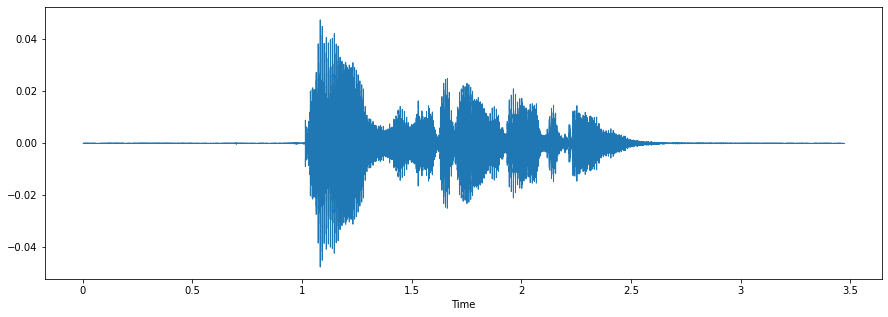

In [9]:
#Displaying one audio recording 

#Emotion = calm, Intensity = 1, Statement= 'dog walking ...', Gender = 'male'
audio_file_path = df['path'][0]
audio_data, sample_rate=librosa.load(audio_file_path)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

# Lets play the audio 
ipd.Audio(audio_file_path)

In [10]:
#Extracting the feature MFCC (Mel Frequency Cepstral Coefficients )

mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfcc.shape

(40, 150)

In [11]:
mfcc

array([[-8.8713831e+02, -8.8610406e+02, -8.8881042e+02, ...,
        -8.8909198e+02, -8.8918695e+02, -8.8918695e+02],
       [ 2.8936043e+00,  4.3299527e+00,  5.3210944e-01, ...,
         1.3418254e-01,  0.0000000e+00,  0.0000000e+00],
       [ 2.8830457e+00,  4.2438974e+00,  5.3082621e-01, ...,
         1.3390970e-01,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 3.2264736e-01,  4.4631025e-01,  6.6146538e-02, ...,
         2.7809571e-02,  0.0000000e+00,  0.0000000e+00],
       [ 2.3675585e-01,  3.7603834e-01,  4.6685830e-02, ...,
         2.2955664e-02,  0.0000000e+00,  0.0000000e+00],
       [ 1.5162438e-01,  3.0591083e-01,  2.7278230e-02, ...,
         1.8070638e-02,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [12]:
#Function to extract feature 
def features_extractor(file):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

# > *Some of the code below are commented to save time*

> *The features are extracted into dataset.*

In [13]:
'''
extracted_features=[]

for file_name in df['path']:
    data=features_extractor(file_name)
    extracted_features.append(data)
'''


"\nextracted_features=[]\n\nfor file_name in df['path']:\n    data=features_extractor(file_name)\n    extracted_features.append(data)\n"

In [14]:
'''
extracted_features = pd.DataFrame(extracted_features)
extracted_features.shape
'''


'\nextracted_features = pd.DataFrame(extracted_features)\nextracted_features.shape\n'

In [15]:
#extracted_features[:10]

In [16]:
'''
df = pd.concat([df, extracted_features], axis=1)
df.head(10)
'''


'\ndf = pd.concat([df, extracted_features], axis=1)\ndf.head(10)\n'

In [17]:
#df.to_csv('RAVDESS_dataset.csv', index=False)

In [18]:
'''
from IPython.display import FileLink
FileLink('RAVDESS_dataset.csv')
'''



"\nfrom IPython.display import FileLink\nFileLink('RAVDESS_dataset.csv')\n"

In [19]:
df = pd.read_csv('../input/ravdess-dataset/RAVDESS_dataset.csv')

In [20]:
#Defining X and y features

X = df.iloc[:,-40:]
y = df['emotion']
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

# No of classes
num_labels=y.shape[1]

In [21]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train = (X_train - X_train.min())/ (X_train.max() - X_train.min())
X_test = (X_test - X_test.min())/ (X_test.max() - X_test.min())


# > *Keras Tuner*

In [22]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
        
    model.add(layers.Dense(num_labels, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [23]:

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    project_name='Voice Sentiment Classification')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until
2022-09-24 21:05:51.790770: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner.search(X_train, y_train,
             epochs=200,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 04m 49s]
val_accuracy: 0.5578703681627909

Best val_accuracy So Far: 0.6504629651705424
Total elapsed time: 00h 14m 45s


In [26]:
tuner.results_summary()

Results summary
Results in ./Voice Sentiment Classification
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 6
units_0: 448
units_1: 160
learning_rate: 0.001
units_2: 320
units_3: 192
units_4: 256
units_5: 448
units_6: 160
units_7: 416
units_8: 256
units_9: 480
units_10: 128
units_11: 256
units_12: 128
Score: 0.6504629651705424
Trial summary
Hyperparameters:
num_layers: 3
units_0: 384
units_1: 480
learning_rate: 0.001
units_2: 448
units_3: 352
units_4: 224
units_5: 160
Score: 0.6342592636744181
Trial summary
Hyperparameters:
num_layers: 6
units_0: 256
units_1: 224
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
Score: 0.5787037014961243
Trial summary
Hyperparameters:
num_layers: 13
units_0: 64
units_1: 128
learning_rate: 0.001
units_2: 480
units_3: 256
units_4: 352
units_5: 416
units_6: 192
units_7: 224
units_8: 64
units_9: 512
units_10: 416
units_11: 128
units_12: 448
Score: 0.5578703681627909
Trial summary
Hyperparameters:
num_layers: 13
units_0:

In [27]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 200 epochs
model = tuner.hypermodel.build(best_hps)


history = model.fit(X_train, y_train, epochs=200,  validation_data=(X_test, y_test), verbose=1)



val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/200
36/36 [==============================] - 1s 13ms/step - loss: 2.0087 - accuracy: 0.1814 - val_loss: 1.8963 - val_accuracy: 0.2500
Epoch 2/200
36/36 [==============================] - 0s 7ms/step - loss: 1.8727 - accuracy: 0.2526 - val_loss: 1.7774 - val_accuracy: 0.2778
Epoch 3/200
36/36 [==============================] - 0s 7ms/step - loss: 1.7955 - accuracy: 0.2613 - val_loss: 1.7681 - val_accuracy: 0.2674
Epoch 4/200
36/36 [==============================] - 0s 8ms/step - loss: 1.7723 - accuracy: 0.2812 - val_loss: 1.7227 - val_accuracy: 0.3021
Epoch 5/200
36/36 [==============================] - 0s 7ms/step - loss: 1.7317 - accuracy: 0.2995 - val_loss: 1.6801 - val_accuracy: 0.3090
Epoch 6/200
36/36 [==============================] - 0s 7ms/step - loss: 1.6582 - accuracy: 0.3420 - val_loss: 1.6501 - val_accuracy: 0.3576
Epoch 7/200
36/36 [==============================] - 0s 7ms/step - loss: 1.7227 - accuracy: 0.3307 - val_loss: 1.6570 - val_accuracy: 0.3681
Epoch 8/200


In [28]:
hypermodel = tuner.hypermodel.build(best_hps)



# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch,  validation_data=(X_test, y_test), verbose=1)

Epoch 1/74
36/36 [==============================] - 1s 13ms/step - loss: 2.0065 - accuracy: 0.1849 - val_loss: 1.8842 - val_accuracy: 0.2396
Epoch 2/74
36/36 [==============================] - 0s 7ms/step - loss: 1.8889 - accuracy: 0.2422 - val_loss: 1.7990 - val_accuracy: 0.2674
Epoch 3/74
36/36 [==============================] - 0s 7ms/step - loss: 1.7877 - accuracy: 0.2639 - val_loss: 1.7599 - val_accuracy: 0.2569
Epoch 4/74
36/36 [==============================] - 0s 9ms/step - loss: 1.7132 - accuracy: 0.3003 - val_loss: 1.6962 - val_accuracy: 0.2812
Epoch 5/74
36/36 [==============================] - 0s 7ms/step - loss: 1.6616 - accuracy: 0.3403 - val_loss: 1.6191 - val_accuracy: 0.3854
Epoch 6/74
36/36 [==============================] - 0s 7ms/step - loss: 1.5924 - accuracy: 0.3733 - val_loss: 1.6226 - val_accuracy: 0.3854
Epoch 7/74
36/36 [==============================] - 0s 8ms/step - loss: 1.5821 - accuracy: 0.3750 - val_loss: 1.6288 - val_accuracy: 0.3264
Epoch 8/74
36/36 [=

In [29]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (32, 448)                 18368     
_________________________________________________________________
dense_22 (Dense)             (32, 160)                 71840     
_________________________________________________________________
dense_23 (Dense)             (32, 320)                 51520     
_________________________________________________________________
dense_24 (Dense)             (32, 192)                 61632     
_________________________________________________________________
dense_25 (Dense)             (32, 256)                 49408     
_________________________________________________________________
dense_26 (Dense)             (32, 448)                 115136    
_________________________________________________________________
dense_27 (Dense)             (32, 8)                  

In [30]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

9/9 [==============================] - 0s 3ms/step - loss: 2.5692 - accuracy: 0.5868
[test loss, test accuracy]: [2.569182872772217, 0.5868055820465088]


# > *Testing with my voice from the model*

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


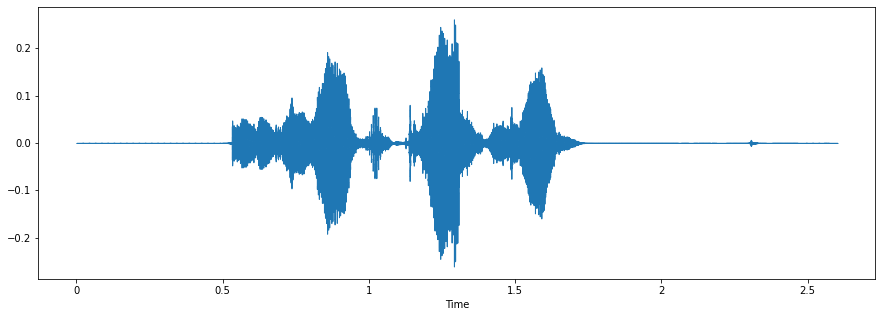

In [31]:
#Displaying our recorded audio

audio_file_path = '../input/voice-testing/test_recording.m4a'
audio_data, sample_rate=librosa.load(audio_file_path)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

# Lets play the audio 
ipd.Audio(audio_file_path)

In [32]:
#Extracting the feature MFCC (Mel Frequency Cepstral Coefficients ) from our recording


mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)


#Scaling the feature
mfccs_scaled_features = (mfccs_scaled_features - mfccs_scaled_features.min())/ (mfccs_scaled_features.max() - mfccs_scaled_features.min())
mfccs_scaled_features


array([0.        , 1.        , 0.8538125 , 0.93112904, 0.88924474,
       0.9255823 , 0.87225354, 0.90987664, 0.9053136 , 0.92136616,
       0.9070438 , 0.91435105, 0.92184144, 0.89156234, 0.92091346,
       0.9114069 , 0.9129566 , 0.9063942 , 0.923477  , 0.90502274,
       0.91192406, 0.9224241 , 0.91211075, 0.9214726 , 0.9192343 ,
       0.9311922 , 0.9072626 , 0.92408866, 0.9222466 , 0.9166237 ,
       0.92108   , 0.919673  , 0.9213158 , 0.91386807, 0.92899275,
       0.91323596, 0.91891754, 0.917799  , 0.9203642 , 0.9212388 ],
      dtype=float32)

In [33]:
#Predicting the model
y_predict = np.argmax(hypermodel.predict(mfccs_scaled_features.reshape(1,-1)), axis=-1)
prediction_class = labelencoder.inverse_transform(y_predict) 
prediction_class[0]

'neutral'

> *Our model predicted the sentiment of voice correctly as fearful.*